In [1]:
import cv2
import tensorflow as tf
from tensorflow import keras
MIN_DISTANCE = 130
import numpy as np
import os
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
print(tf.__version__)

2.5.0


In [8]:
# Connecting to GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# Changing to the working directory to access sample images
%cd /content/gdrive/MyDrive/42028/A3
!ls

/content/gdrive/MyDrive/42028/A3
 archive.zip			 'FMD_SSD(廢棄請勿使用).ipynb'
'DLCNN_FMD(廢棄請勿使用).ipynb'   MODEL
 DL-FMD.7z			  model.png
'Face Mask Dataset'		  ssd_inception_v2_coco_2018_01_28
 FMD_MODEL.ipynb


In [9]:
train_dir = '/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Train'
test_dir = '/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Test'
val_dir = '/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Validation'
face_model = cv2.CascadeClassifier('/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/haarcascade_frontalface_default.xml')


In [ ]:
filepath = '/content/gdrive/MyDrive/42028/A3/MODEL/weights.{epoch:03d}-{val_loss:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                             save_weights_only=False, mode='auto', period=1)

In [10]:
import matplotlib.pyplot as plt
def preview():
  img = cv2.imread('/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Testing/images.jpg')
  faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)  # returns a list of (x,y,w,h) tuples
  out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  for (x, y, w, h) in faces:
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (0, 0, 255), 1)
      
  plt.figure(figsize=(3,3))
  plt.imshow(out_img)

  # image =[]
  # for i in range(69,74):
  #   img=cv2.imread('/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Train/WithMask/'+str(i)+'.png')
  #   print(np.shape(img))
  #   img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
  #   image.append(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) #colored output image

  # f,axes  = plt.subplots(ncols=5,nrows=1,figsize=(10,2))
  # for i in  range(1,5):
  #   axes[i].axis('Off')
  #   axes[i] = f.add_subplot(1,5,i)
  #   axes[i].imshow(image[(i)])
  #   axes[i].axis('Off')

  # image =[]
  # for i in range(20,25):
  #   img=cv2.imread('/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Train/WithoutMask/'+str(i)+'.png') 
  #   print(np.shape(img))
  #   img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
  #   image.append(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) #colored output image

  # f,axes  = plt.subplots(ncols=5,nrows=1,figsize=(10,2))
  # for i in  range(1,5):
  #   axes[i].axis('Off')
  #   axes[i] = f.add_subplot(1,5,i)
  #   axes[i].imshow(image[(i)])
  #   axes[i].axis('Off')


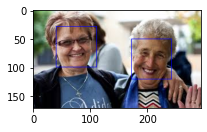

In [11]:
preview()

(150, 150, 3)
(105, 105, 3)
(50, 50, 3)
(53, 53, 3)
(37, 37, 3)
(85, 85, 3)
(93, 93, 3)
(111, 111, 3)
(110, 110, 3)
(125, 125, 3)


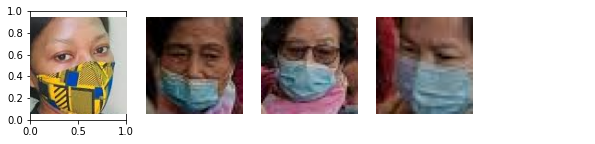

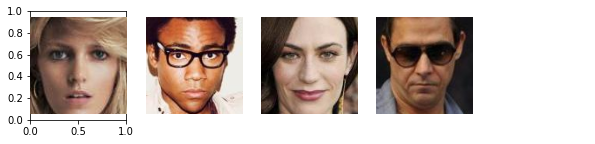

In [ ]:
preview()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2)  # data aurgment

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    class_mode='categorical',
    classes=['WithMask', 'WithoutMask'],
    batch_size=32)

val_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128, 128),
    class_mode='categorical',
    classes=['WithMask', 'WithoutMask'],
    batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# VGG19

In [ ]:
vgg19 = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3))

for layer in vgg19.layers:
    layer.trainable = False


80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer=RMSprop(lr=1e-4),
                  loss="categorical_crossentropy",
                  metrics=['acc'])

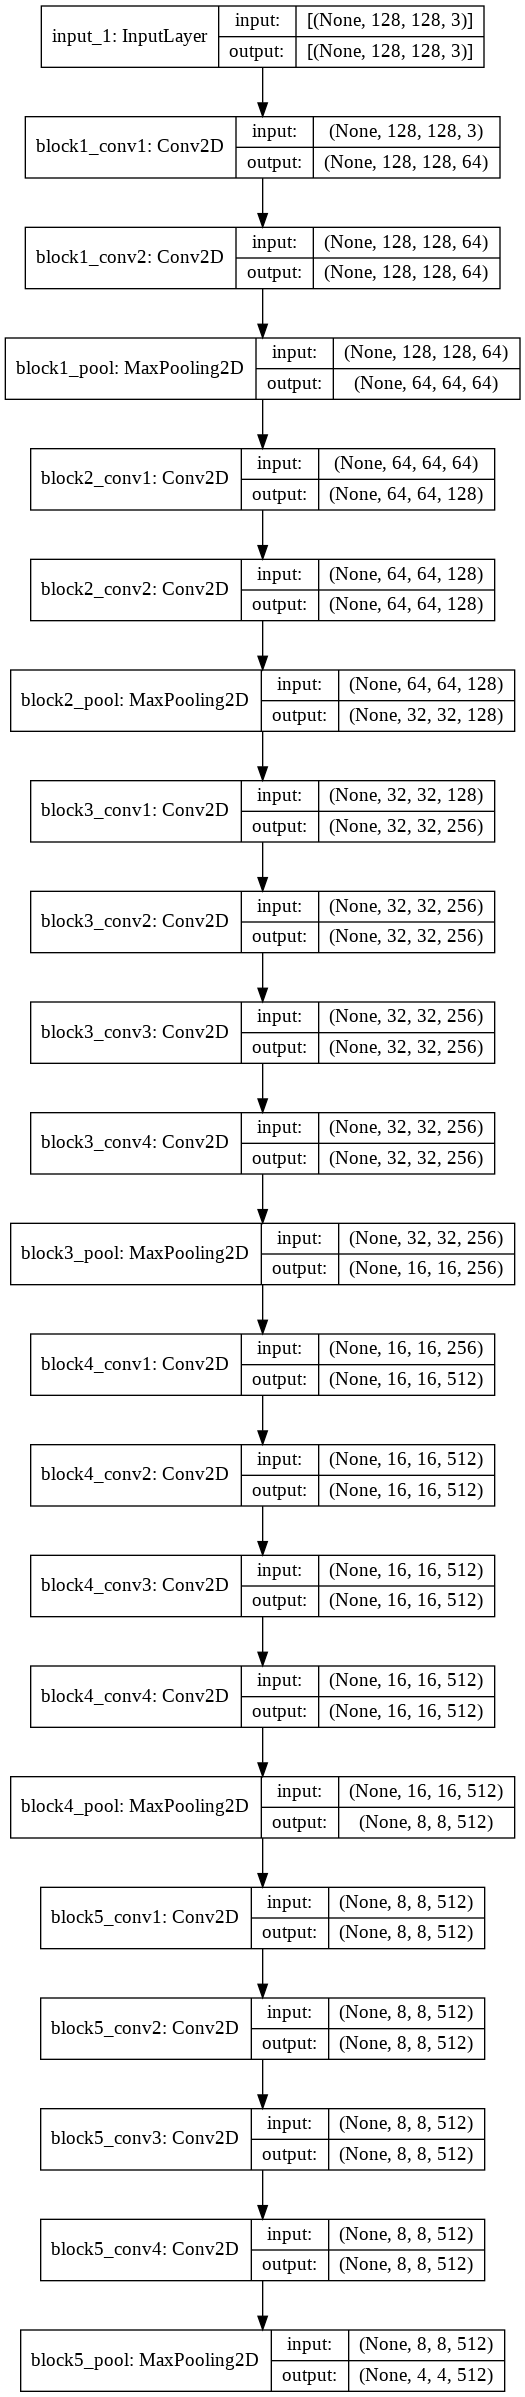

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vgg19, to_file='model.png',show_layer_names=True, show_shapes=True,rankdir='TB')

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=100,  # 2000 images = batch_size * steps,   10000 = 100 * steps
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=8,  # 1000 images = batch_size * steps, 800= 50 *steps
                              # callbacks=[checkpoint],
                              verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 - 883s - loss: 0.3049 - acc: 0.9147 - val_loss: 0.2079 - val_acc: 0.9297
Epoch 2/20
100/100 - 738s - loss: 0.1500 - acc: 0.9616 - val_loss: 0.1454 - val_acc: 0.9648
Epoch 3/20
100/100 - 730s - loss: 0.1189 - acc: 0.9655 - val_loss: 0.1006 - val_acc: 0.9805
Epoch 4/20
100/100 - 728s - loss: 0.0855 - acc: 0.9744 - val_loss: 0.0794 - val_acc: 0.9766
Epoch 5/20
100/100 - 724s - loss: 0.0764 - acc: 0.9771 - val_loss: 0.0758 - val_acc: 0.9688
Epoch 6/20
100/100 - 729s - loss: 0.0749 - acc: 0.9762 - val_loss: 0.0631 - val_acc: 0.9883
Epoch 7/20
100/100 - 725s - loss: 0.0595 - acc: 0.9841 - val_loss: 0.0599 - val_acc: 0.9766
Epoch 8/20
100/100 - 727s - loss: 0.0553 - acc: 0.9853 - val_loss: 0.0680 - val_acc: 0.9727
Epoch 9/20
100/100 - 732s - loss: 0.0531 - acc: 0.9831 - val_loss: 0.0448 - val_acc: 0.9922
Epoch 10/20
100/100 - 726s - loss: 0.0553 - acc: 0.9812 - val_loss: 0.0613 - val_acc: 0.9766
Epoch 11/20
100/100 - 730s - loss: 0.0500 - acc: 0.9841 - val_loss: 0.0532 - va

In [ ]:
   model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.evaluate_generator(train_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.036492008715867996, 0.9890999794006348]

In [ ]:
# model=tf.keras.models.load_model('/content/gdrive/MyDrive/42028/A3/MODEL/weights.019-0.02.hdf5') # Complete the code

In [ ]:
model.evaluate_generator(val_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.043201904743909836, 0.9862499833106995]

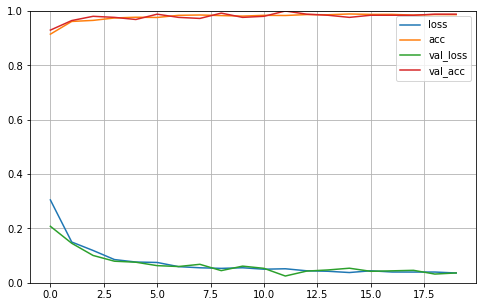

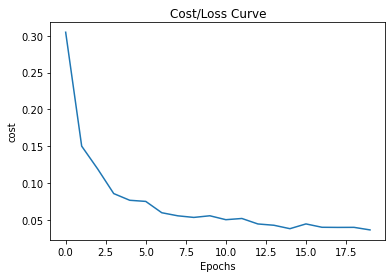

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

plt.plot(history.history['loss'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.title("Cost/Loss Curve")
plt.show()

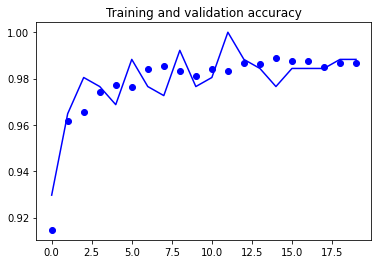

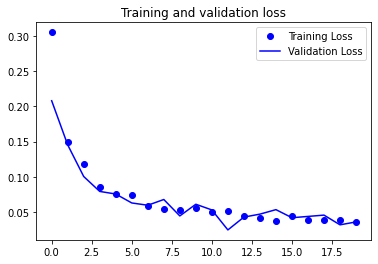

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[1]
[0]
[1]
[0]
[1]
[0]
Faces detected 6 WithMask 3 WithoutMask 3


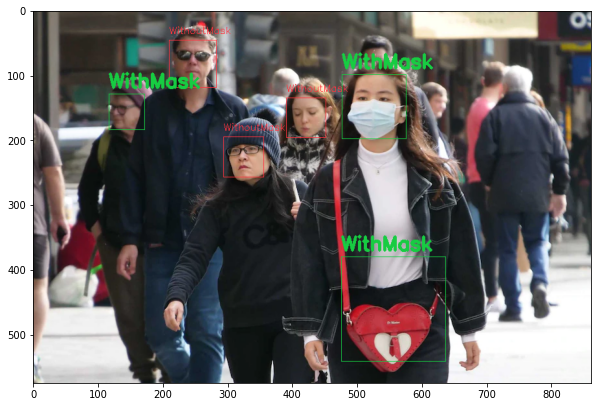

In [6]:
face_model = cv2.CascadeClassifier('/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/haarcascade_frontalface_default.xml') 
model = tf.keras.models.load_model('/content/gdrive/MyDrive/42028/A3/MODEL/FMD.h5')	
img = cv2.imread(
      '/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Testing/71b90743308e424c28f5f8fa1ffb4acc.jpg') #/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Testing/71b90743308e424c28f5f8fa1ffb4acc.jpg
faces = face_model.detectMultiScale(img, scaleFactor=1.05, minNeighbors=10)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
withmasknum = 0
withoutmasknum = 0
for i in range(len(faces)):
    (x, y, w, h) = faces[i]
    crop = out_img[y:y + h, x:x + w]
    crop = cv2.resize(crop, (128, 128))
    crop = np.reshape(crop, [1, 128, 128, 3]) / 255.0
    mask_label = model.predict_classes(crop)
    if (mask_label == 0):#print(mask_label)  0 :WithMask, 1 :'WithoutMask'
      text="WithMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (23, 204, 66), 1) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1,(23, 204, 66),3) # font color
      withmasknum += 1 
    elif (mask_label ==1):
      text="WithoutMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (255, 51, 63), 1) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255, 51, 63),1)
      withoutmasknum += 1
    # crop = cv2.resize(out_img, (300, 300))
    print(mask_label)
print ("Faces detected",len(faces) , "WithMask", withmasknum,"WithoutMask", withoutmasknum )
plt.figure(figsize=(10,10))
plt.imshow(out_img)

#InceptionResNetV2

In [ ]:
InceptionResNetV2 = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    classifier_activation="softmax",
    input_shape=(128, 128, 3))

for layer in InceptionResNetV2.layers:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(InceptionResNetV2)
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=1e-5),
                  loss="categorical_crossentropy",
                  metrics=['acc'])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(InceptionResNetV2, to_file='model.png',show_layer_names=True, show_shapes=True,rankdir='TB')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# model=tf.keras.models.load_model('/content/gdrive/MyDrive/42028/A3/MODEL/InceptionResNetV2_weights.015-0.00.hdf5') # Complete the code

In [ ]:
filepath = '/content/gdrive/MyDrive/42028/A3/MODEL/InceptionResNetV2_weights_31.{epoch:03d}-{val_loss:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='auto', period=1)

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=100,  # 2000 images = batch_size * steps,   10000 = 100 * steps
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=8,  # 1000 images = batch_size * steps, 800= 50 *steps
                              callbacks=[checkpoint],
                              verbose=2)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 - 299s - loss: 0.4910 - acc: 0.8003 - val_loss: 0.2474 - val_acc: 0.9258
Epoch 2/20
100/100 - 221s - loss: 0.1708 - acc: 0.9450 - val_loss: 0.0976 - val_acc: 0.9688
Epoch 3/20
100/100 - 223s - loss: 0.1163 - acc: 0.9598 - val_loss: 0.0888 - val_acc: 0.9688
Epoch 4/20
100/100 - 226s - loss: 0.0835 - acc: 0.9731 - val_loss: 0.0346 - val_acc: 0.9883
Epoch 5/20
100/100 - 224s - loss: 0.0741 - acc: 0.9775 - val_loss: 0.0494 - val_acc: 0.9844
Epoch 6/20
100/100 - 222s - loss: 0.0622 - acc: 0.9819 - val_loss: 0.0401 - val_acc: 0.9922
Epoch 7/20
100/100 - 223s - loss: 0.0574 - acc: 0.9834 - val_loss: 0.0556 - val_acc: 0.9844
Epoch 8/20
100/100 - 221s - loss: 0.0509 - acc: 0.9841 - val_loss: 0.0375 - val_acc: 0.9883
Epoch 9/20
100/100 - 224s - loss: 0.0552 - acc: 0.9843 - val_loss: 0.0491 - val_acc: 0.9766
Epoch 10/20
100/100 - 228s - loss: 0.0467 - acc: 0.9869 - val_loss: 0.0208 - val_acc: 0.9922
Epoch 11/20
100/100 - 228s - loss: 0.0522 - acc: 0.9847 - val_loss: 0.0150 - va

In [ ]:
model.save("/content/gdrive/MyDrive/42028/A3/MODEL/FMD_31.h5")

In [ ]:
 model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 12290     
Total params: 54,349,026
Trainable params: 12,290
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
 InceptionResNetV2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [ ]:
model.evaluate_generator(train_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.036278579384088516, 0.989799976348877]

In [ ]:
model.evaluate_generator(val_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.028132976964116096, 0.9950000047683716]

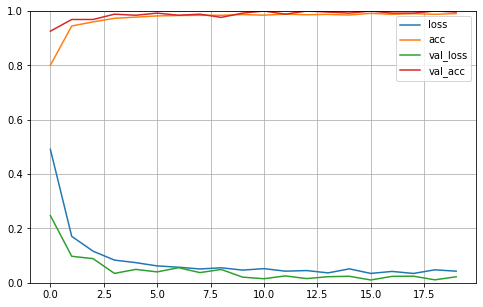

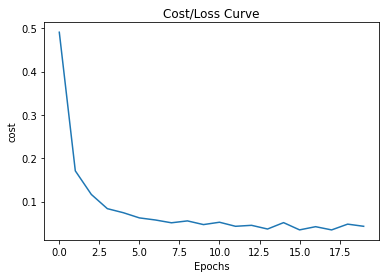

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

plt.plot(history.history['loss'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.title("Cost/Loss Curve")
plt.show()

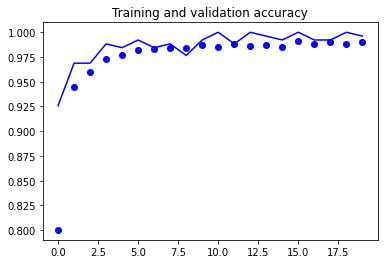

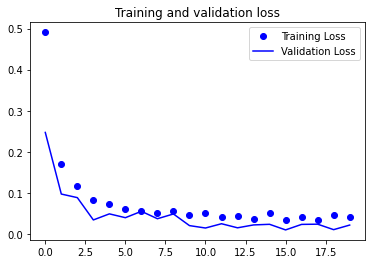

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# filepath='/content/gdrive/MyDrive/42028/A3/MODEL/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
# checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


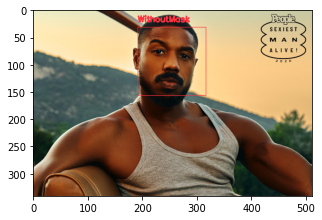

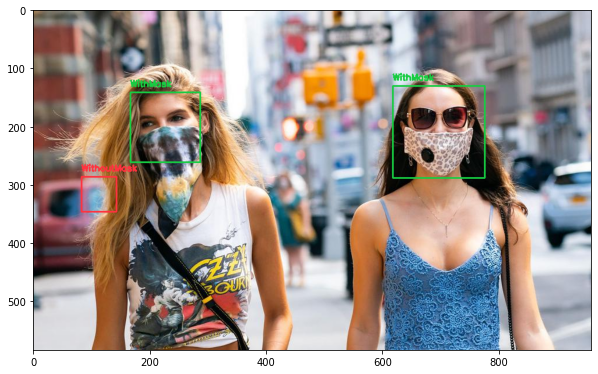

In [ ]:
img = cv2.imread(
      '/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Testing/unnamed.jpg')
faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for i in range(len(faces)):
    (x, y, w, h) = faces[i]
    crop = out_img[y:y + h, x:x + w]
    crop = cv2.resize(crop, (128, 128))
    crop = np.reshape(crop, [1, 128, 128, 3]) / 255.0
    mask_label = model.predict_classes(crop)
    if (mask_label == 0):#print(mask_label)  0 :WithMask, 1 :'WithoutMask'
      text="WithMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (23, 204, 66), 1) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(23, 204, 66),2) # font color
    elif (mask_label ==1):
      text="WithoutMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (255, 51, 63), 1) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255, 51, 63),2)
    # crop = cv2.resize(out_img, (300, 300))
    # print(mask_label)
plt.figure(figsize=(5,5))
plt.imshow(out_img)

img = cv2.imread(
      '/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Testing/b.jpg')
faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for i in range(len(faces)):
    (x, y, w, h) = faces[i]
    crop = out_img[y:y + h, x:x + w]
    crop = cv2.resize(crop, (128, 128))
    crop = np.reshape(crop, [1, 128, 128, 3]) / 255.0
    mask_label = model.predict_classes(crop)
    if (mask_label == 0):#print(mask_label)  0 :WithMask, 1 :'WithoutMask'
      text="WithMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (23, 204, 66), 2) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(23, 204, 66),2) # font color
    elif (mask_label ==1):
      text="WithoutMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (255, 51, 63), 2) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255, 51, 63),2)
    # crop = cv2.resize(out_img, (300, 300))
    # print(mask_label)
plt.figure(figsize=(10,10))
plt.imshow(out_img)

# Customized Model

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 50 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
       train_dir ,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=100, # !!50 image a times
        classes=['WithMask', 'WithoutMask'],
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 50 using test_datagen generator
val_generator = validation_datagen.flow_from_directory(
       val_dir,
        target_size=(150,150),
        batch_size=100,
        classes=['WithMask', 'WithoutMask'],
        class_mode='binary'
        )


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy', #optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy"
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc']
              )

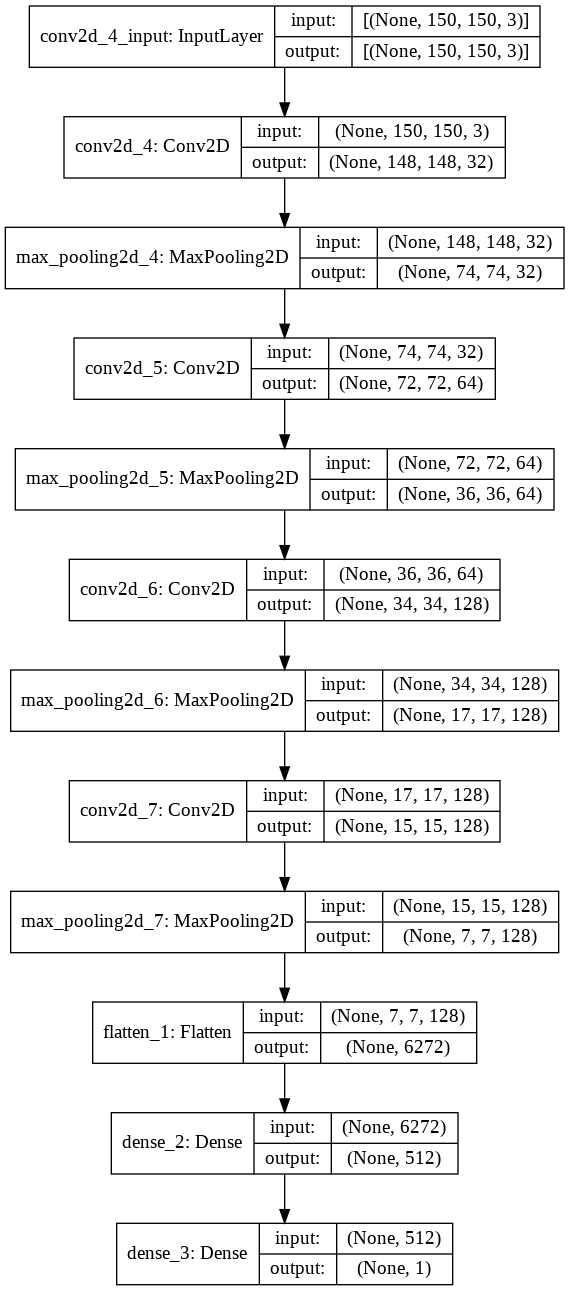

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_layer_names=True, show_shapes=True,rankdir='TB')

In [ ]:
filepath = '/content/gdrive/MyDrive/42028/A3/MODEL/Customized_weights_1705.{epoch:03d}-{val_loss:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='auto', period=1)
       

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,  # 2000 images = batch_size * steps,   10000 = 100 * steps
                              epochs=15,
                              validation_data=val_generator,
                              validation_steps=8,  # 1000 images = batch_size * steps, 800= 50 *steps
                              callbacks=[checkpoint],
                              verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
100/100 - 454s - loss: 0.2724 - acc: 0.8844 - val_loss: 0.1345 - val_acc: 0.9588
Epoch 2/15
100/100 - 464s - loss: 0.1101 - acc: 0.9618 - val_loss: 0.0618 - val_acc: 0.9787
Epoch 3/15
100/100 - 457s - loss: 0.0707 - acc: 0.9734 - val_loss: 0.0405 - val_acc: 0.9862
Epoch 4/15
100/100 - 457s - loss: 0.0519 - acc: 0.9796 - val_loss: 0.0356 - val_acc: 0.9875
Epoch 5/15
100/100 - 454s - loss: 0.0386 - acc: 0.9845 - val_loss: 0.0255 - val_acc: 0.9900
Epoch 6/15
100/100 - 455s - loss: 0.0304 - acc: 0.9885 - val_loss: 0.0123 - val_acc: 0.9962
Epoch 7/15
100/100 - 455s - loss: 0.0260 - acc: 0.9901 - val_loss: 0.0149 - val_acc: 0.9937
Epoch 8/15
100/100 - 455s - loss: 0.0218 - acc: 0.9923 - val_loss: 0.0170 - val_acc: 0.9925
Epoch 9/15
100/100 - 455s - loss: 0.0185 - acc: 0.9936 - val_loss: 0.0077 - val_acc: 0.9975
Epoch 10/15
100/100 - 463s - loss: 0.0169 - acc: 0.9943 - val_loss: 0.0135 - val_acc: 0.9962
Epoch 11/15
100/100 - 456s - loss: 0.0139 - acc: 0.9952 - val_loss: 0.0091 - va

In [ ]:
model.evaluate_generator(train_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.004752425476908684, 0.9988999962806702]

In [ ]:
model.evaluate_generator(val_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.004752426408231258, 0.9988999962806702]

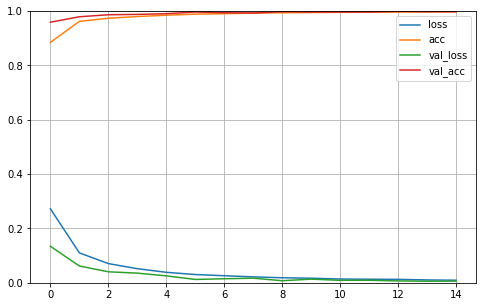

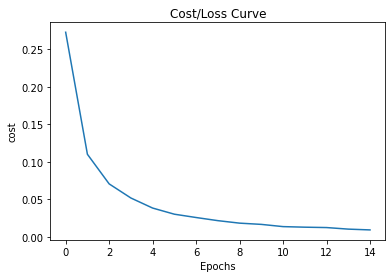

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

plt.plot(history.history['loss'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.title("Cost/Loss Curve")
plt.show()

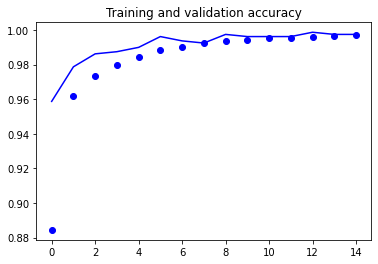

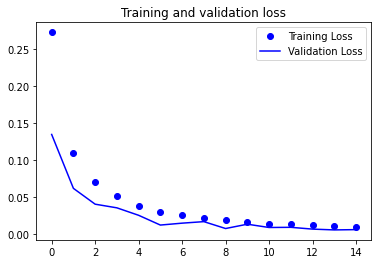

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
img = cv2.imread(
      '/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Testing/unnamed.jpg')
faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for i in range(len(faces)):
    (x, y, w, h) = faces[i]
    crop = out_img[y:y + h, x:x + w]
    crop = cv2.resize(crop, (128, 128))
    crop = np.reshape(crop, [1, 128, 128, 3]) / 255.0
    mask_label = model.predict_classes(crop)
    if (mask_label == 0):#print(mask_label)  0 :WithMask, 1 :'WithoutMask'
      text="WithMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (23, 204, 66), 1) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1,(23, 204, 66),3) # font color
    elif (mask_label ==1):
      text="WithoutMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (255, 51, 63), 1) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 51, 63),3)
    # crop = cv2.resize(out_img, (300, 300))
    print(mask_label)
plt.figure(figsize=(5,5))
plt.imshow(out_img)

img = cv2.imread(
      '/content/gdrive/MyDrive/42028/A3/Face Mask Dataset/Testing/b.jpg')
faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for i in range(len(faces)):
    (x, y, w, h) = faces[i]
    crop = out_img[y:y + h, x:x + w]
    crop = cv2.resize(crop, (128, 128))
    crop = np.reshape(crop, [1, 128, 128, 3]) / 255.0
    mask_label = model.predict_classes(crop)
    if (mask_label == 0):#print(mask_label)  0 :WithMask, 1 :'WithoutMask'
      text="WithMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (23, 204, 66), 1) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1,(23, 204, 66),3) # font color
    elif (mask_label ==1):
      text="WithoutMask"
      cv2.rectangle(out_img, (x, y), (x + w, y + h), (255, 51, 63), 1) # the bounfding box color 255, 51, 63 red
      cv2.putText(out_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 51, 63),3)
    # crop = cv2.resize(out_img, (300, 300))
    print(mask_label)
plt.figure(figsize=(10,10))
plt.imshow(out_img)